In [4]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build dataset

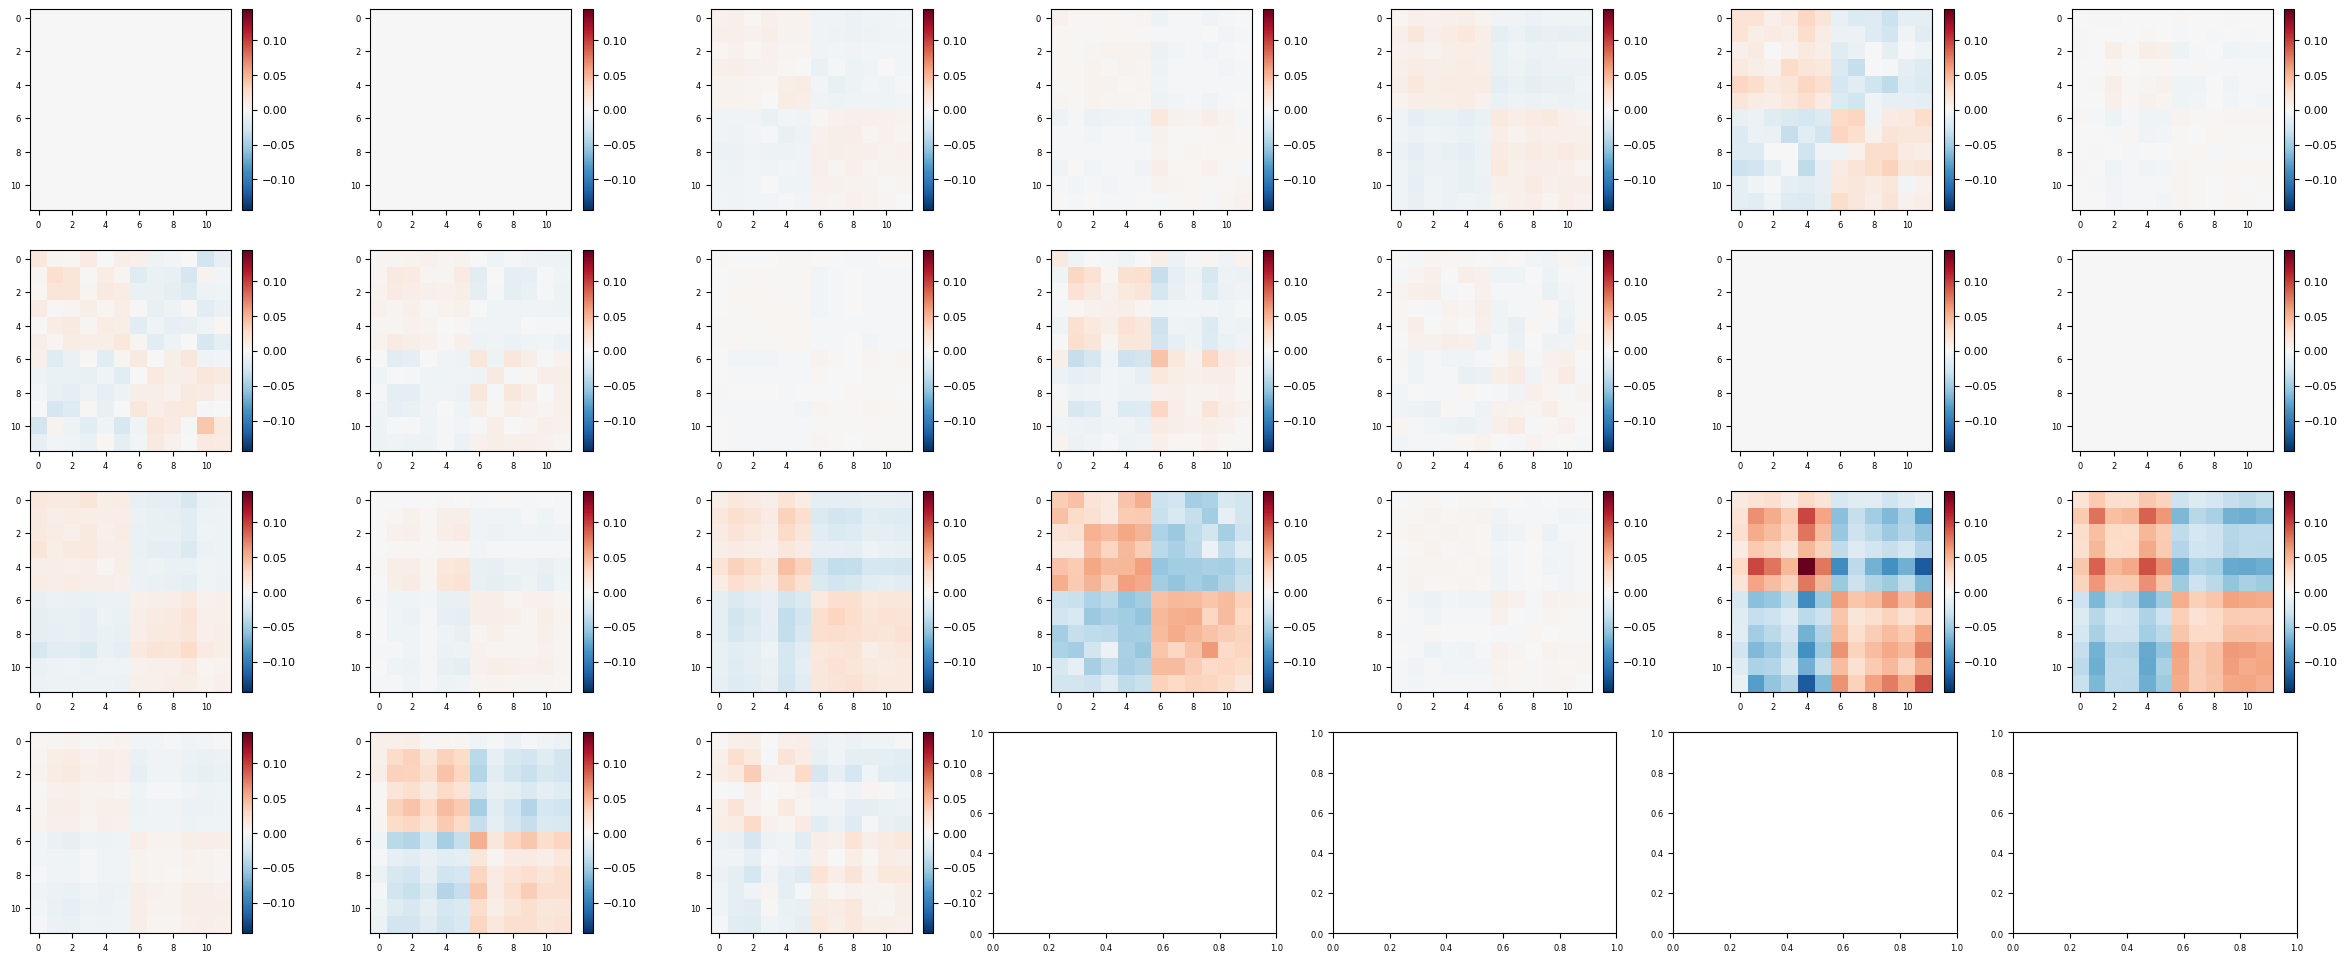

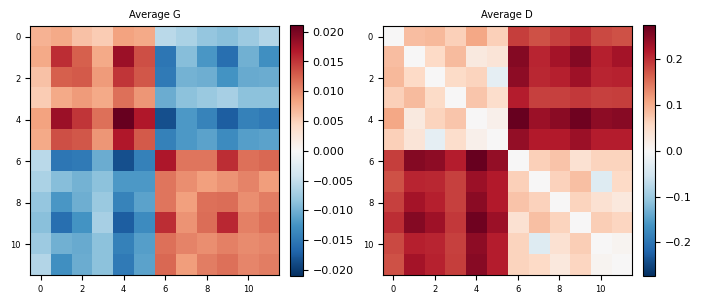

In [91]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[2]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        Y = data_tmp[i_sub][idx, :]
        
        subj_part = part_tmp[i_sub][idx]
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(4,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
plt.tight_layout()
plt.show() 




# Build models

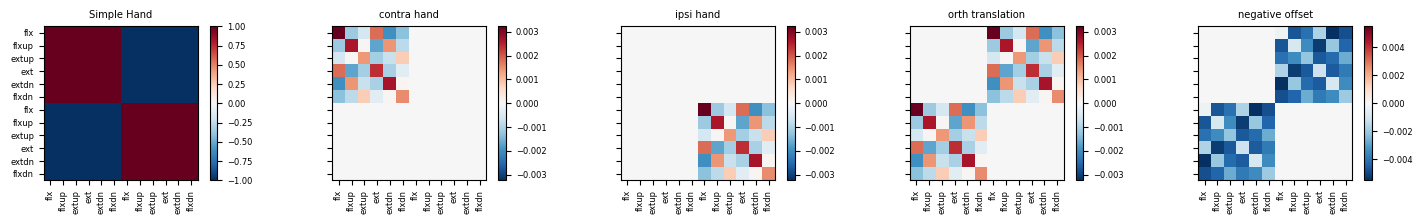

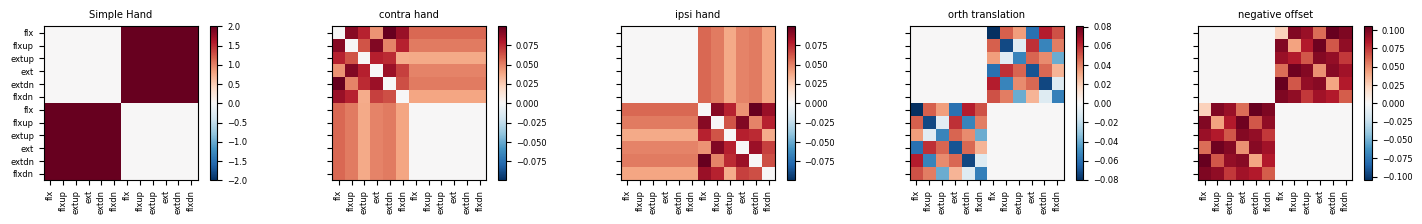

In [ ]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
cov[6:12, 6:12] = 1
cov[0:6, 6:12] = -1
cov[6:12, 0:6] = -1
M_hand = pcm.FixedModel('null', cov)
M.append(M_hand)
modelG['Simple Hand'] = [cov]

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi hand'] = [cov]

# Orthogonal translation hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
# cov = np.zeros((ncond, ncond))
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
modelG['orth translation'] = [cov]

# negative offset:
cov = np.zeros((ncond, ncond))
offset = np.max(G_ceil)
cov[0:6, 6:12] = G_ceil - offset - 0.0003
cov[6:12, 0:6] = G_ceil - offset - 0.0003
# M.append(pcm.FixedModel('negative offset', cov))
modelG['negative offset'] = [cov]

# component models:
M.append(pcm.ComponentModel('only within_structure (orthogonal contra-ipsi)', [modelG['Simple Hand'][0], modelG['contra hand'][0], modelG['ipsi hand'][0]]))
M.append(pcm.ComponentModel('within_structure+across_covariance', [modelG['Simple Hand'][0], modelG['contra hand'][0], modelG['ipsi hand'][0], modelG['orth translation'][0]]))
M.append(pcm.ComponentModel('within_structure+negative_offset', [modelG['Simple Hand'][0], modelG['contra hand'][0], modelG['ipsi hand'][0], modelG['negative offset'][0]]))

# ================ noise ceiling ================
# noise ceiling model:
# M_ceil = pcm.model.FreeModel('ceil',ncond)
# RDMs = pd.read_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))
# RDMs = RDMs[(RDMs['region']==region) & (RDMs['hem']=='L')]
# RDMs = RDMs.G.values
# G_avg = np.zeros((ncond,ncond))
# for tmp in RDMs:
#     G_avg += tmp/len(RDMs)
# M_ceil = pcm.FixedModel('ceil', G_avg)
# M.append(M_ceil)

# PLOT:
n = len(modelG)
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    D = pcm.G_to_dist(modelG[list(modelG.keys())[i]][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit models

In [69]:
# FIT Models:
# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)



Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3


Plot

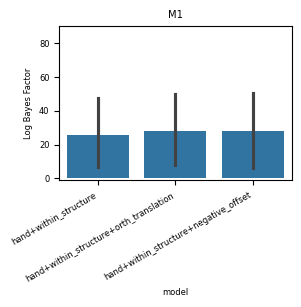

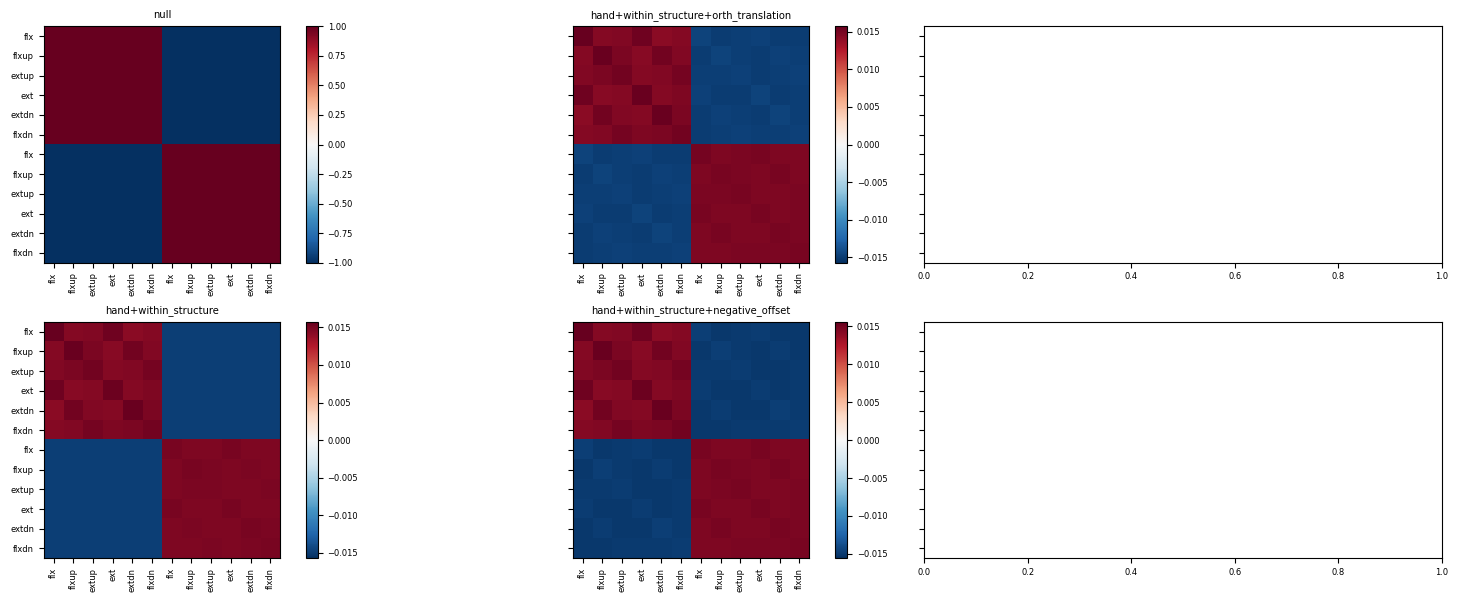

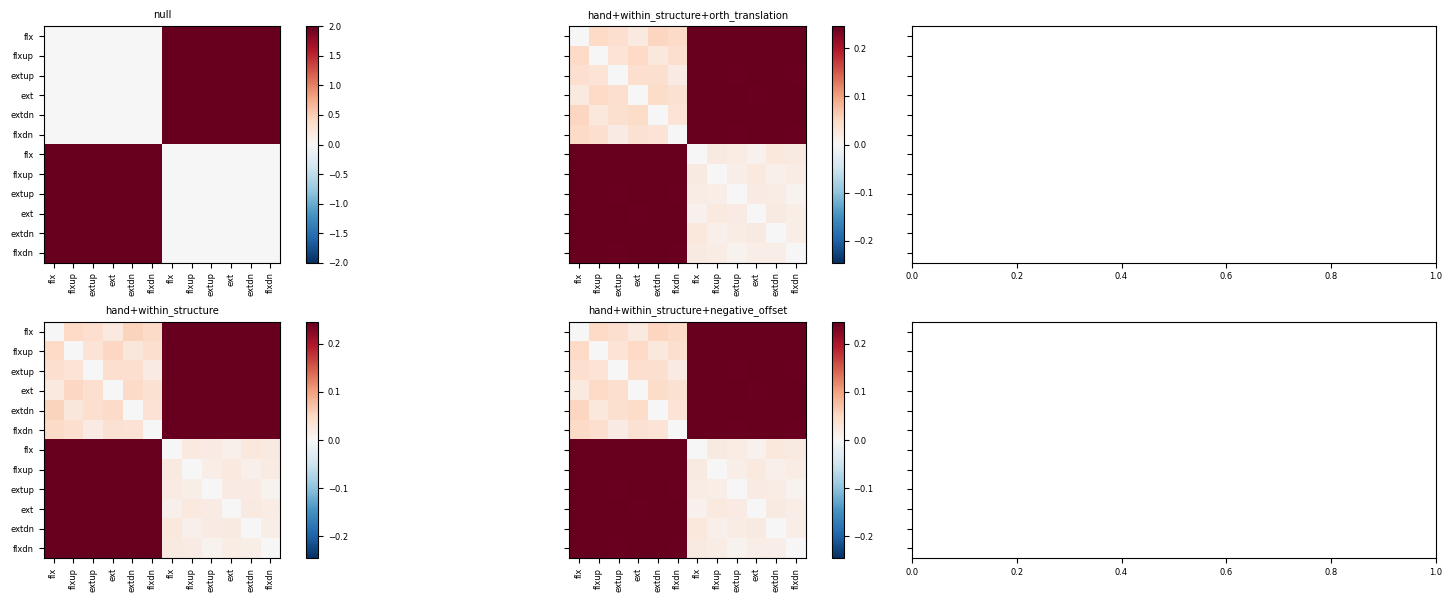

In [70]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
tmp_ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
# angle the x axis labels:
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim(-1, 90)
plt.show()

nmodels = len(M)

# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(2, nmodels//2+1, figsize=(16,6), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,nmodels//2+1, figsize=(16,6), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i%2, i//2].set_title(M[i].name)
    ax[i%2, i//2].set_xticks(list(range(12)))
    ax[i%2, i//2].set_xticklabels(labels, rotation=90)
    ax[i%2, i//2].set_yticks(list(range(12)))
    ax[i%2, i//2].set_yticklabels(labels)
    plt.colorbar(ax[i%2, i//2].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i%2, i//2])
plt.tight_layout()
plt.show()

